<a href="https://colab.research.google.com/github/monikamikhaiel/Automating-Real-World-Tasks-with-Python-/blob/main/AntennaPositionningipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np  # for array stuff and random
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.

style.use("ggplot")  # setting our style!

In [2]:
# area

SIZE_W = 5
SIZE_H = 5


In [3]:
HM_EPISODES = 5
epsilon = 0.9  # randomness
EPS_DECAY = 0.9999  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 100  # how often to play through env visually.

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95

ANTENNA_N = 1  # player key in dict

# the dict! Using just for colors
d = {1: (255, 175, 0) }  # Antenna color blue
#SNR RANGES
snr_range={"highSNR_max":-50,"highSNR_min":-80,
           "mediumSNR_max":-90,"mediumSNR_min":-100,
          "deadzone":-120}

In [4]:
#antenna
class antenna:
    def __init__(self):
        self.x = np.random.randint(0, SIZE_W)
        self.y = np.random.randint(0, SIZE_H)
    def __str__(self):
        return f"{self.x}, {self.y}"
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:  #up
            self.move(x=0, y=1)
        elif choice == 1:  #down
            self.move(x=0, y=-1)
        elif choice == 2:  #left
            self.move(x=-1, y=0)
        elif choice == 3:    #right
            self.move(x=1, y=0)

    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE_W-1:
            self.x = SIZE_W-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE_H-1:
            self.y = SIZE_H-1



In [5]:
ant = antenna()
print(ant)
ant.action(0)
print(ant)


2, 1
1, 2


In [6]:
x = SIZE_W # Building X
y = SIZE_H # Building Y
z = 4 # actions

q_table = np.zeros((x, y, z))
# q_table *= 0
print(q_table.shape)


(5, 5, 4)


In [7]:
def measureSNR (ant,SIZE_H,SIZE_W):
  Gain_pannel=7 #in db
  Gain=[]
  attenuation= 13 #in db function of frequency and distance 
  freq= 2.4*(10^9) # the frequency og the signal
  c= 3*(10^8) # the speed of light
  #hte = input("please enter the height of the transmitter antenna ? ")
  #hre = input("please enter the height of the receiver antenna ? ")
  hte= 20
  hre= 2
  G_hte = 10*np.log(int(hte) /200) 
  G_hre = 10*np.log(int(hre)/ 3)
  G_Area =27 # (Quasi Open Area)
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference == [0,0]:
        continue
      else:
        distance=pow((pow(difference[0],2)+pow(difference[1],2)),0.5)
        FPL      = 20*np.log(4*np.pi*distance*freq/c)
        Path_Loss = FPL + attenuation - G_hte - G_hre - G_Area
        Gain.append(Gain_pannel-Path_Loss)
#      return np.random.random((1,(SIZE_W*SIZE_H)))
    
  return Gain

print(measureSNR (ant,SIZE_H,SIZE_W))

[-76.441797210628, -67.27888989188646, -60.34741808628699, -67.27888989188646, -76.441797210628, -74.21036169748591, -60.34741808628699, -60.34741808628699, -74.21036169748591, -76.441797210628, -67.27888989188646, -60.34741808628699, -67.27888989188646, -76.441797210628, -81.14183350308535, -76.441797210628, -74.21036169748591, -76.441797210628, -81.14183350308535, -85.99691166090237, -83.37326901622747, -82.3196638596492, -83.37326901622747, -85.99691166090237]


In [8]:
def calSNRlow(SNR):
    counter =0
    for i in range(len(SNR)):
        if int(SNR[i]) < snr_range["deadzone"]:
            counter+=1
    percent=counter*100/len(SNR)
    #return percent
    return np.mean(SNR)

calSNRlow(measureSNR (ant,SIZE_H,SIZE_W))

-73.96378302037496

In [9]:
episode_rewards = []
reward=0
for episode in range(HM_EPISODES):
    ant = antenna()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}")
       # print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    state=0
    for i in range(200):
        antennaPos = (ant) # Current Antenna X, Y Co-ord.

        if np.random.random() > epsilon:
            # GET THE ACTION
#             if state <=25:
#                 state=0
#             else:
#                 state+=1

            action = np.argmax(q_table[ant.x][ant.y])
        else:
            action = np.random.randint(0, 3)
        # Take the action!
        ant.action(action)
        ###
        #calculate the SNR
        snr= measureSNR(ant,SIZE_H,SIZE_W)
        percent=calSNRlow(snr)
        ##
        reward=percent*-1
          ###
        #current_q = q_table[state][action]
        newAntennaPos = (ant)
        current_q = q_table[ant.x][ant.y][action] # Current State
        max_future_q = np.max(q_table[ant.x][ant.y]) # Max State
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[ant.x][ant.y][action] = new_q


        episode_reward += reward

        #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

on #0


In [10]:
if snr >snr_range["highSNR_min"]:
    reward+= highSNR_REWARD
elif snr < snr_range["mediumSNR_max"] and  snr > snr_range["mediumSNR_min"]:
    reward+= mediumSNR_PENALTY
elif snr < snr_range["deadzone"]:
    reward-=lowSNR_PENALTY


TypeError: ignored

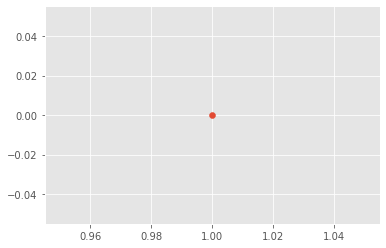

In [11]:
plt.scatter(ant.x, ant.y)
plt.show()